<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Comparative Study of Latest Models for TwitterSentiment Analysis (Assignment2)


In [1]:
# Silent installation 
!pip install -U tensorflow zhon transformers sentencepiece &> /dev/null
# Download dataset and lib files from the github
!git clone https://github.com/cardiffnlp/tweeteval.git &> /dev/null
!git clone https://github.com/gibsonx/grocery.git &> /dev/null

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, layers, losses, preprocessing, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,confusion_matrix,f1_score

#Import customized classes and libraries from file
sys.path.insert(0, '/content/grocery/')
from CE888_Transformer import DataPrep, imbalance_under_sampling , create_model, get_tokenization, warmup
from CustomizedPlots import *
try:
    %tensorflow_version 2.x
except Exception:
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#1.Data nominalization for training , validation and test datasets (Hate, Irony and Offensive)

In [3]:
#Define the root folder where we put the datasets
base_dir = '/content/tweeteval/datasets/'

#Create hate dataframe
hate = DataPrep(base_dir, 'hate') 
hate_dict_train, hate_dict_val, hate_dict_test = hate.dataframe()
df_hate = hate.dataframe_merge()
not_hate, hate = hate.binary_split()

#Create irony dataframe
irony = DataPrep(base_dir, 'irony') 
irony_dict_train, irony_dict_val, irony_dict_test = irony.dataframe()
df_irony = irony.dataframe_merge()
not_irony, irony = irony.binary_split()

#Create offensive dataframe
offensive = DataPrep(base_dir, 'offensive')
offensive_dict_train, offensive_dict_val, offensive_dict_test = offensive.dataframe()
df_offensive = offensive.dataframe_merge()
not_offensive, offensive = offensive.binary_split()

print("The sample of pre-precessed dataset is shown below:")
hate.head()

The sample of pre-precessed dataset is shown below:


,text,label
0,a woman who you fucked multiple times saying y...,1
1,real talk do you have eyes or were they gouge...,1
2,your girlfriend lookin at me like a groupie in...,1
3,i am not going after your ex bf you lieing sac...,1
4,send home migrants not in need of protection p...,1


The samples in the datasets are imbalance, so we make the training dataset balanced using function "imbalance_under_sampling"

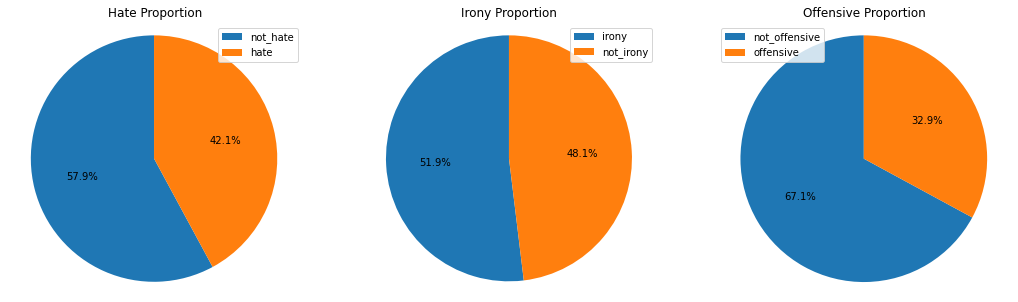

In [4]:
Proportion_chart(df_hate,hate,not_hate,df_irony,irony,not_irony,df_offensive,offensive,not_offensive)

In [5]:
hate_dict_train = imbalance_under_sampling(hate_dict_train)
irony_dict_train = imbalance_under_sampling(irony_dict_train)
offensive_dict_train = imbalance_under_sampling(offensive_dict_train)

#2.Downloading Models and Tokenizations from HuggingFace

In [6]:
from transformers import TFXLNetModel, XLNetTokenizer, TFDistilBertModel, DistilBertTokenizer

xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

for layer in xlnet_model.layers:
    layer.trainable = True
for layer in dbert_model.layers:
    layer.trainable = True

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


#3.Word Embeddings using XLNet tokenizier, which consist of tokens and attention masks

In [7]:
#DistilBert Tokenizer
dl_hate_train_input = get_tokenization(hate_dict_train['text'], dbert_tokenizer)
dl_hate_val_input = get_tokenization(hate_dict_val['text'], dbert_tokenizer)
dl_hate_test_input = get_tokenization(hate_dict_test['text'], dbert_tokenizer)

dl_irony_train_input = get_tokenization(irony_dict_train['text'], dbert_tokenizer)
dl_irony_val_input = get_tokenization(irony_dict_val['text'], dbert_tokenizer)
dl_irony_test_input = get_tokenization(irony_dict_test['text'], dbert_tokenizer)

dl_offensive_train_input = get_tokenization(offensive_dict_train['text'], dbert_tokenizer)
dl_offensive_val_input = get_tokenization(offensive_dict_val['text'], dbert_tokenizer)
dl_offensive_test_input = get_tokenization(offensive_dict_test['text'], dbert_tokenizer)

#XLNet Tokenizer
xl_hate_train_input = get_tokenization(hate_dict_train['text'], xlnet_tokenizer)
xl_hate_val_input = get_tokenization(hate_dict_val['text'], xlnet_tokenizer)
xl_hate_test_input = get_tokenization(hate_dict_test['text'], xlnet_tokenizer)

xl_irony_train_input = get_tokenization(irony_dict_train['text'], xlnet_tokenizer)
xl_irony_val_input = get_tokenization(irony_dict_val['text'], xlnet_tokenizer)
xl_irony_test_input = get_tokenization(irony_dict_test['text'], xlnet_tokenizer)

xl_offensive_train_input = get_tokenization(offensive_dict_train['text'], xlnet_tokenizer)
xl_offensive_val_input = get_tokenization(offensive_dict_val['text'], xlnet_tokenizer)
xl_offensive_test_input = get_tokenization(offensive_dict_test['text'], xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

#4.Apply DistilBert as the 1st model to predict classifcation.


4.1 DistilBert for Hate Dataset

In [8]:
DistilBert_hate = create_model(dbert_model)
DistilBert_hate.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

#CallBacks for all attempts of training

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, min_delta=0.001, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [10]:
hist_dl_hate = DistilBert_hate.fit(x=dl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 75s 138ms/step - loss: 0.6259 - accuracy: 0.6368 - precision: 0.6354 - recall: 0.6513 - val_loss: 0.5340 - val_accuracy: 0.7230 - val_precision: 0.6794 - val_recall: 0.6651
Epoch 2/25
473/473 [==============================] - 63s 133ms/step - loss: 0.4141 - accuracy: 0.8224 - precision: 0.8230 - recall: 0.8149 - val_loss: 0.5474 - val_accuracy: 0.7300 - val_precision: 0.6592 - val_recall: 0.7611
Epoch 3/25
473/473 [==============================] - 63s 133ms/step - loss: 0.2344 - accuracy: 0.9068 - precision: 0.9015 - recall: 0.9146 - val_loss: 0.6274 - val_accuracy: 0.7270 - val_precision: 0.6869 - val_recall: 0.6628
Epoch 4/25
473/473 [==============================] - 63s 133ms/step - loss: 0.1316 - accuracy: 0.9501 - precision: 0.9480 - recall: 0.9516 - val_loss: 0.8757 - val_accuracy: 0.7230 - val_precision: 0.6359 - val_recall: 0.8220
Epoch 5/25
473/473 [==============================] - 63s 133ms/step - loss: 0.0510 - accura

In [11]:
preds_dl_hate = DistilBert_hate.predict(dl_hate_test_input, verbose=True)

93/93 [==============================] - 9s 79ms/step


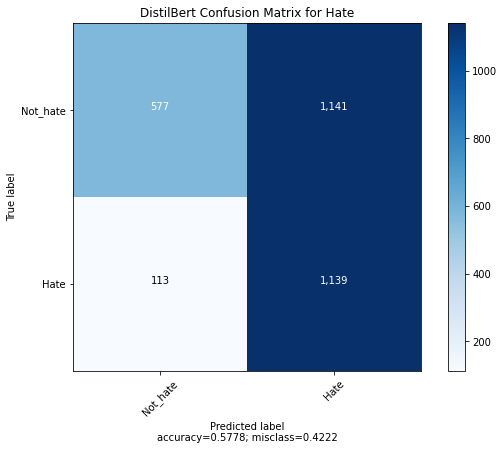

In [12]:
hate_pred_dl_label = [i[0] for i in preds_dl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_dl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="DistilBert Confusion Matrix for Hate")

In [13]:
f1_dl_hate = f1_score(hate_dict_test.label,hate_pred_dl_label,average='macro')
print("F1_score of Hate dataset with DistilBert is: %.1f%%" % round(f1_dl_hate*100,1))

F1_score of Hate dataset with DistilBert is: 56.2%


4.2 DistilBert for Irony Dataset

In [14]:
DistilBert_irony = create_model(dbert_model)
hist_irony = DistilBert_irony.fit(x=dl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 36s 153ms/step - loss: 0.7144 - accuracy: 0.5176 - precision_1: 0.5175 - recall_1: 0.5678 - val_loss: 0.6536 - val_accuracy: 0.6126 - val_precision_1: 0.5837 - val_recall_1: 0.6579
Epoch 2/25
178/178 [==============================] - 25s 142ms/step - loss: 0.5485 - accuracy: 0.7236 - precision_1: 0.7299 - recall_1: 0.6972 - val_loss: 0.6426 - val_accuracy: 0.6429 - val_precision_1: 0.6139 - val_recall_1: 0.6798
Epoch 3/25
178/178 [==============================] - 25s 143ms/step - loss: 0.3649 - accuracy: 0.8539 - precision_1: 0.8789 - recall_1: 0.8239 - val_loss: 0.7116 - val_accuracy: 0.6555 - val_precision_1: 0.6348 - val_recall_1: 0.6557
Epoch 4/25
178/178 [==============================] - 25s 142ms/step - loss: 0.1444 - accuracy: 0.9594 - precision_1: 0.9662 - recall_1: 0.9529 - val_loss: 0.9495 - val_accuracy: 0.6492 - val_precision_1: 0.6247 - val_recall_1: 0.6645
Epoch 5/25
178/178 [==============================] - 25s 14

In [15]:
preds_dl_irony = DistilBert_irony.predict(dl_irony_test_input, verbose=True)

25/25 [==============================] - 4s 78ms/step


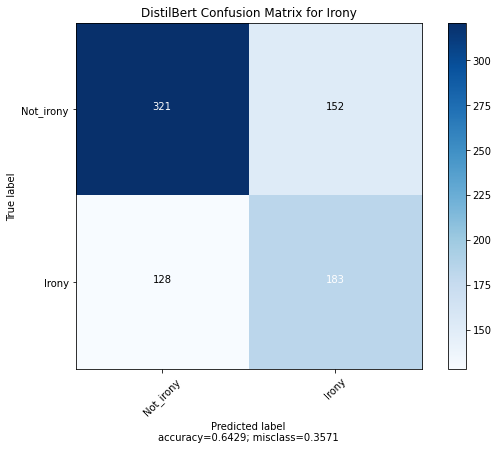

In [16]:
irony_pred_dl_label = [i[0] for i in preds_dl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_dl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="DistilBert Confusion Matrix for Irony")

In [17]:
f1_dl_irony = f1_score(irony_dict_test.label,irony_pred_dl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_dl_irony*100,1))

F1_score of irony dataset with DistilBert is: 63.1%


4.3 DistilBert for Offensive Dataset

In [18]:
DistilBert_offensive = create_model(dbert_model)
hist_dl_offensive = DistilBert_offensive.fit(x=dl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(dl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 77s 139ms/step - loss: 0.6196 - accuracy: 0.6519 - precision_2: 0.6527 - recall_2: 0.6382 - val_loss: 0.4781 - val_accuracy: 0.7825 - val_precision_2: 0.7221 - val_recall_2: 0.6057
Epoch 2/25
493/493 [==============================] - 66s 134ms/step - loss: 0.4219 - accuracy: 0.8003 - precision_2: 0.8102 - recall_2: 0.7864 - val_loss: 0.5739 - val_accuracy: 0.7319 - val_precision_2: 0.5774 - val_recall_2: 0.8453
Epoch 3/25
493/493 [==============================] - 66s 134ms/step - loss: 0.2569 - accuracy: 0.8934 - precision_2: 0.8992 - recall_2: 0.8906 - val_loss: 0.5825 - val_accuracy: 0.7742 - val_precision_2: 0.6606 - val_recall_2: 0.7168
Epoch 4/25
493/493 [==============================] - 66s 134ms/step - loss: 0.1165 - accuracy: 0.9578 - precision_2: 0.9624 - recall_2: 0.9545 - val_loss: 0.8766 - val_accuracy: 0.7470 - val_precision_2: 0.6026 - val_recall_2: 0.7930
Epoch 5/25
493/493 [==============================] - 66s 13

In [19]:
preds_dl_offensive = DistilBert_offensive.predict(dl_offensive_test_input, verbose=True)

27/27 [==============================] - 4s 80ms/step


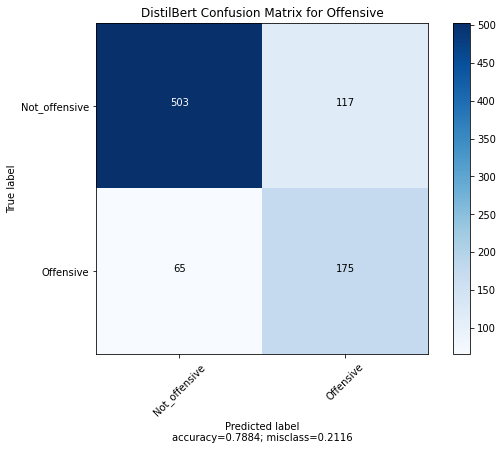

In [20]:
offensive_pred_dl_label = [i[0] for i in preds_dl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_dl_label)
plot_confusion_matrix(cm, normalize=False, target_names=['Not_offensive', 'Offensive'],title="DistilBert Confusion Matrix for Offensive")

In [21]:
f1_dl_offensive = f1_score(offensive_dict_test.label,offensive_pred_dl_label,average='macro')
print("F1_score of offensive dataset with DistilBert is: %.1f%%" % round(f1_dl_offensive*100,1))

F1_score of offensive dataset with DistilBert is: 75.2%


#5. Apply XLNet as the 2nd model to predict classifcation.

5.1 XLnet for Hate Dataset

In [22]:
XLNet_hate = create_model(xlnet_model)
XLNet_hate.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_ids (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
word_attention (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxl_net_model (TFXLNetModel)   TFXLNetModelOutput(l 116718336   word_ids[0][0]                   
                                                                 word_attention[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 1, 768)       0           tfxl_net_model[0][0]       

In [23]:
hist_xl_hate = XLNet_hate.fit(x=xl_hate_train_input, y=hate_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_hate_val_input, hate_dict_val.label), callbacks=callbacks)

Epoch 1/25
473/473 [==============================] - 166s 319ms/step - loss: 0.7292 - accuracy: 0.5751 - precision_3: 0.5806 - recall_3: 0.5259 - val_loss: 0.5634 - val_accuracy: 0.7100 - val_precision_3: 0.6952 - val_recall_3: 0.5714
Epoch 2/25
473/473 [==============================] - 148s 313ms/step - loss: 0.5232 - accuracy: 0.7439 - precision_3: 0.7444 - recall_3: 0.7505 - val_loss: 0.6418 - val_accuracy: 0.6830 - val_precision_3: 0.5865 - val_recall_3: 0.8735
Epoch 3/25
473/473 [==============================] - 148s 313ms/step - loss: 0.4230 - accuracy: 0.8102 - precision_3: 0.8124 - recall_3: 0.8068 - val_loss: 0.6231 - val_accuracy: 0.7130 - val_precision_3: 0.6268 - val_recall_3: 0.8103
Epoch 4/25
473/473 [==============================] - 148s 313ms/step - loss: 0.3410 - accuracy: 0.8631 - precision_3: 0.8595 - recall_3: 0.8767 - val_loss: 0.6142 - val_accuracy: 0.7160 - val_precision_3: 0.6538 - val_recall_3: 0.7119
Epoch 5/25
473/473 [==============================] - 14

In [24]:
preds_xl_hate = XLNet_hate.predict(xl_hate_test_input, verbose=True)

93/93 [==============================] - 20s 186ms/step


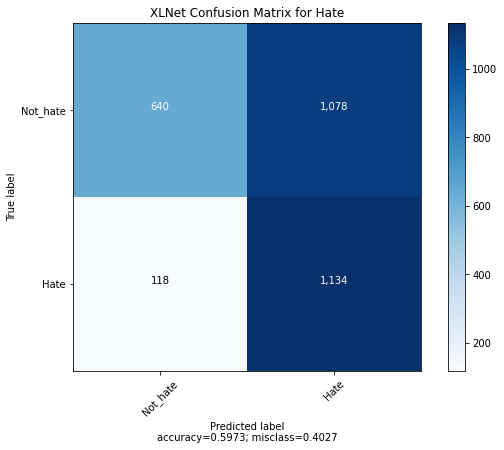

In [25]:
hate_pred_xl_label = [i[0] for i in preds_xl_hate.round().astype(int)]
cm = confusion_matrix(hate_dict_test.label,hate_pred_xl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_hate', 'Hate'],title="XLNet Confusion Matrix for Hate")

In [26]:
f1_xl_hate = f1_score(hate_dict_test.label,hate_pred_xl_label,average='macro')
print("F1_score of Hate dataset with XLnet is: %.1f%%" % round(f1_xl_hate*100,1))

F1_score of Hate dataset with XLnet is: 58.6%


XLnet for Irony Dataset

In [27]:
XLNet_irony = create_model(xlnet_model)

In [28]:
hist_xl_irony = XLNet_irony.fit(x=xl_irony_train_input, y=irony_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_irony_val_input, irony_dict_val.label), callbacks=callbacks)

Epoch 1/25
178/178 [==============================] - 77s 348ms/step - loss: 0.7786 - accuracy: 0.5212 - precision_4: 0.5191 - recall_4: 0.4937 - val_loss: 0.7004 - val_accuracy: 0.5026 - val_precision_4: 0.4895 - val_recall_4: 0.9759
Epoch 2/25
178/178 [==============================] - 59s 333ms/step - loss: 0.6308 - accuracy: 0.6368 - precision_4: 0.6432 - recall_4: 0.6745 - val_loss: 0.6234 - val_accuracy: 0.6586 - val_precision_4: 0.6720 - val_recall_4: 0.5570
Epoch 3/25
178/178 [==============================] - 59s 333ms/step - loss: 0.5082 - accuracy: 0.7574 - precision_4: 0.7923 - recall_4: 0.7050 - val_loss: 0.6367 - val_accuracy: 0.6712 - val_precision_4: 0.6355 - val_recall_4: 0.7303
Epoch 4/25
178/178 [==============================] - 59s 333ms/step - loss: 0.3307 - accuracy: 0.8677 - precision_4: 0.8832 - recall_4: 0.8458 - val_loss: 0.9299 - val_accuracy: 0.6482 - val_precision_4: 0.5906 - val_recall_4: 0.8575
Epoch 5/25
178/178 [==============================] - 59s 33

In [29]:
preds_xl_irony = XLNet_irony.predict(xl_irony_test_input, verbose=True)

25/25 [==============================] - 7s 183ms/step


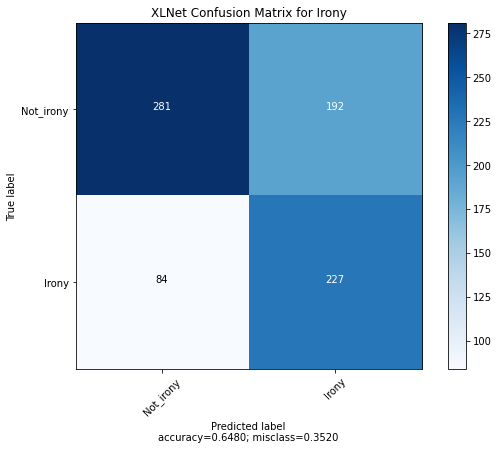

In [30]:
irony_pred_xl_label = [i[0] for i in preds_xl_irony.round().astype(int)]
cm = confusion_matrix(irony_dict_test.label,irony_pred_xl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_irony', 'Irony'],title="XLNet Confusion Matrix for Irony")

In [31]:
f1_xl_irony = f1_score(irony_dict_test.label,irony_pred_xl_label,average='macro')
print("F1_score of irony dataset with DistilBert is: %.1f%%" % round(f1_xl_irony * 100,1))

F1_score of irony dataset with DistilBert is: 64.6%


5.3 XLnet for Offensive Dataset

In [32]:
XLNet_offensive = create_model(xlnet_model)

In [33]:
hist_xl_offensive = XLNet_offensive.fit(x=xl_offensive_train_input, y=offensive_dict_train.label, epochs=25, batch_size=16, validation_data=(xl_offensive_val_input, offensive_dict_val.label), callbacks=callbacks)

Epoch 1/25
493/493 [==============================] - 175s 323ms/step - loss: 0.6539 - accuracy: 0.6260 - precision_5: 0.6347 - recall_5: 0.6245 - val_loss: 0.4914 - val_accuracy: 0.7545 - val_precision_5: 0.6070 - val_recall_5: 0.8279
Epoch 2/25
493/493 [==============================] - 156s 316ms/step - loss: 0.4375 - accuracy: 0.8089 - precision_5: 0.8237 - recall_5: 0.7761 - val_loss: 0.5190 - val_accuracy: 0.7500 - val_precision_5: 0.6067 - val_recall_5: 0.7930
Epoch 3/25
493/493 [==============================] - 156s 316ms/step - loss: 0.3293 - accuracy: 0.8678 - precision_5: 0.8729 - recall_5: 0.8597 - val_loss: 0.6145 - val_accuracy: 0.7470 - val_precision_5: 0.6095 - val_recall_5: 0.7516
Epoch 4/25
493/493 [==============================] - 156s 316ms/step - loss: 0.1907 - accuracy: 0.9306 - precision_5: 0.9359 - recall_5: 0.9255 - val_loss: 0.9123 - val_accuracy: 0.7326 - val_precision_5: 0.5901 - val_recall_5: 0.7495
Epoch 5/25
493/493 [==============================] - 15

In [34]:
preds_xl_offensive = XLNet_offensive.predict(xl_offensive_test_input, verbose=True)

27/27 [==============================] - 7s 186ms/step


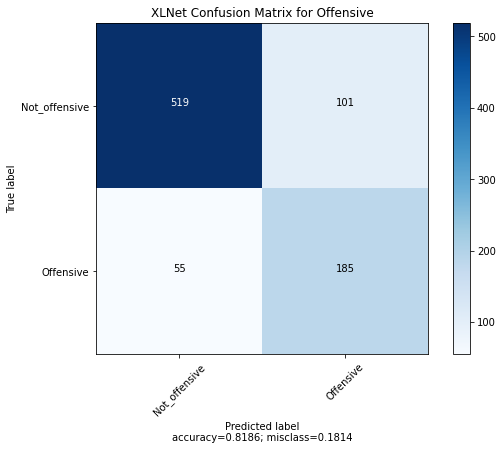

In [35]:
offensive_pred_xl_label = [i[0] for i in preds_xl_offensive.round().astype(int)]
cm = confusion_matrix(offensive_dict_test.label,offensive_pred_xl_label)
plot_confusion_matrix(cm, normalize=False,target_names=['Not_offensive', 'Offensive'],title="XLNet Confusion Matrix for Offensive")

In [36]:
f1_xl_offensive = f1_score(offensive_dict_test.label,offensive_pred_xl_label,average='macro')
print("F1_score of offensive dataset with XLNet is: %.1f%%" % round(f1_xl_offensive * 100,1))

F1_score of offensive dataset with XLNet is: 78.6%


#6. Graphs for comparing the result

6.1 Comparasion For Macro F1 score 

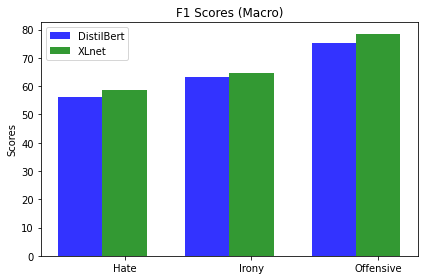

In [37]:
f1_score_bar(f1_dl_hate,f1_dl_irony,f1_dl_offensive,f1_xl_hate,f1_xl_irony,f1_xl_offensive)    

6.2 AUC Performance

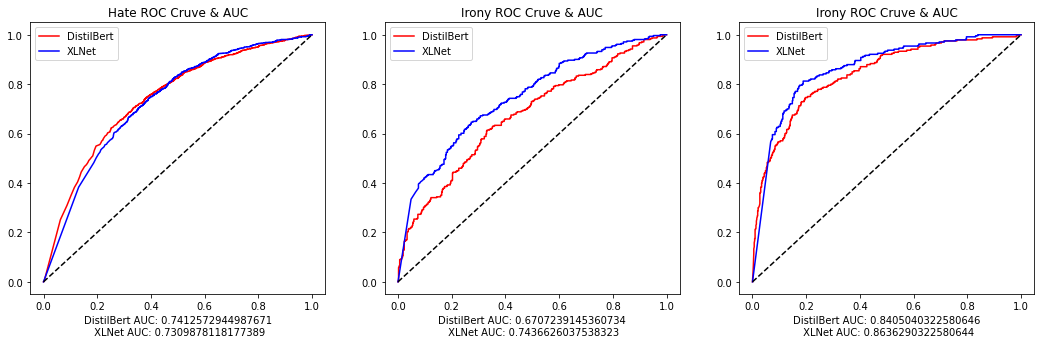

In [38]:
auc_plot_metrics(preds_dl_hate, preds_xl_hate, hate_dict_test.label,
         preds_dl_irony, preds_xl_irony, irony_dict_test.label,
         preds_dl_offensive, preds_xl_offensive, offensive_dict_test.label)